In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os
import sys
from model import predict_img
sys.path.append("../main/")
from unet import UNet
import cv2
from Otsu import OTSU
from CurveDetect import CurveDetect

In [2]:
TRAIN_FILE_ROOT = "/data/unagi0/kanayama/dataset/nuclei_images/stage1_train_default/"
TRAIN_FILE_ROOT4 =  "/data/unagi0/kanayama/dataset/nuclei_images/stage1_train_default4/"
TEST_FILE_ROOT =  "/data/unagi0/kanayama/dataset/nuclei_images/stage1_test/"
ANSWER_FILE_ROOT =  "/data/unagi0/kanayama/dataset/nuclei_images/answer/"
VALIDATION_FILE_ROOT = "/data/unagi0/kanayama/dataset/nuclei_images/answer_val/"

In [3]:
def post_process(predicted_mask_array, iterations):
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(predicted_mask_array, kernel, iterations=iterations)
    dilation = cv2.dilate(erosion, kernel, iterations=iterations)
    return dilation

In [4]:
# validation画像の場合は、元画像に予測値と正解を重ねて表示する
# test画像の場合は、元画像に予測値のみ表示する
def show_prediction(original_image_array, predicted_mask_array, gt_mask_array=None, iterations=0):  
        
    _, contours, hierarchy = cv2.findContours(predicted_mask_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    dst = cv2.drawContours(original_image_array, contours, -1, (0, 255, 0), 1)
    
    if gt_mask_array is not None:
        _, contours, hierarchy = cv2.findContours(gt_mask_array, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        dst = cv2.drawContours(dst, contours, -1, (255, 0, 0), 1)
        
    return Image.fromarray(dst)

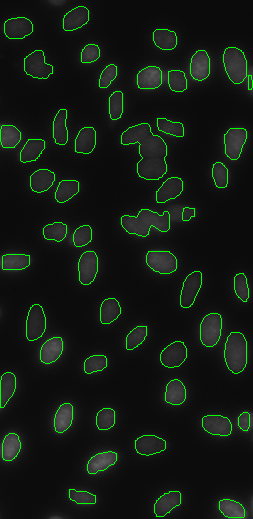

In [5]:
filename = 'a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f'
#filename = 'a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d'
#filename = '44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078'
#filename = '472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71'
#filename = "259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4"  # HE
#filename = "17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff"  # HE

original_image =  Image.open(TEST_FILE_ROOT + filename + '/images/' + filename + ".png")
predicted_mask =  Image.open(ANSWER_FILE_ROOT + filename + ".png")
original_image_array = np.asarray(original_image)
predicted_mask_array = np.asarray(predicted_mask)

# 予測値に対して何らかの後処理を施す
#predicted_mask_array = post_process(predicted_mask_array, iterations=3)  

dst = show_prediction(original_image_array, predicted_mask_array)
dst

In [7]:
curve = CurveDetect(predicted_mask_array)

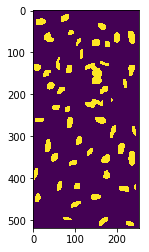

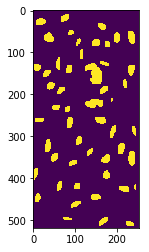

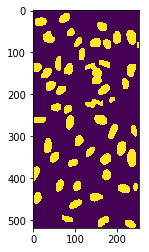

In [9]:
curve.show()

In [ ]:
#白黒
#filename = "f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1"
#filename = "fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de"
filename = "2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707"
#filename = "0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426"

#紫
#filename = "0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6"
#filename = "4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20"
filename = "aa58ba4512955771b4f9b459cb4e6a8adb71d11cd6cae662ec2df31d688a5fe0"
filename = "1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72"
#filename = "c0f172831b8017c769ff0e80f85b096ac939e79de3d524e0826fbb95221365da"

original_image =  Image.open(TRAIN_FILE_ROOT + '/images/' + filename + ".png")
predicted_mask = Image.open(VALIDATION_FILE_ROOT + filename + ".png")
gt_mask = Image.open(TRAIN_FILE_ROOT + '/masks/' + filename + ".png")
original_image_array = np.asarray(original_image)[:, :, :3].copy() # なぜかcopyを入れないと動かない・・・
predicted_mask_array = np.asarray(predicted_mask)
gt_mask_array = np.asarray(gt_mask)

dst = show_prediction(original_image_array, predicted_mask_array, gt_mask_array)
dst

In [ ]:
# 大津の2値化を適用
#白黒
#filename = "f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1"
#filename = "fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de"
filename = "2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707"
#filename = "0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426"

#紫
#filename = "0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6"
filename = "4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20"
#filename = "aa58ba4512955771b4f9b459cb4e6a8adb71d11cd6cae662ec2df31d688a5fe0"
#filename = "1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72"
#filename = "c0f172831b8017c769ff0e80f85b096ac939e79de3d524e0826fbb95221365da"

original_image =  Image.open(TRAIN_FILE_ROOT + '/images/' + filename + ".png")
gt_mask = Image.open(TRAIN_FILE_ROOT + '/masks/' + filename + ".png")
original_image_array = np.asarray(original_image)[:, :, :3].copy() # なぜかcopyを入れないと動かない・・・
gt_mask_array = np.asarray(gt_mask)

#大津の2値化を用いて予測
otsu = OTSU(TRAIN_FILE_ROOT + '/images/' + filename + ".png")
predicted_mask_array = otsu.data()
# 予測値に対して何らかの後処理を施す
predicted_mask_array = post_process(predicted_mask_array, iterations=0)  

dst = show_prediction(original_image_array, predicted_mask_array, gt_mask_array)
dst

In [ ]:
Image.fromarray(predicted_mask_array)

In [ ]:
predicted_mask_array